In [2]:
import csv
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
from collections import deque
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import load_model


from env_test import GridEnvironment
from DQL_agent import DQNAgent
from DQL_agent_noreplay import DQNAgent_nr

In [3]:
#NEW DATA TEST
caiso=pd.read_csv("CAISO_zone_1_.csv")

In [4]:
caiso.head

<bound method NDFrame.head of                         time  load_power  wind_power  solar_power  DHI  DNI  \
0        2018-01-01 00:00:00    0.785327    0.004276          0.0  0.0  0.0   
1        2018-01-01 00:01:00    0.784770    0.004346          0.0  0.0  0.0   
2        2018-01-01 00:02:00    0.784213    0.004416          0.0  0.0  0.0   
3        2018-01-01 00:03:00    0.783657    0.004486          0.0  0.0  0.0   
4        2018-01-01 00:04:00    0.783100    0.004556          0.0  0.0  0.0   
...                      ...         ...         ...          ...  ...  ...   
1573918  2020-12-30 23:56:00    0.847004    0.002288          0.0  0.0  0.0   
1573919  2020-12-30 23:57:00    0.846690    0.002437          0.0  0.0  0.0   
1573920  2020-12-30 23:58:00    0.846377    0.002587          0.0  0.0  0.0   
1573921  2020-12-30 23:59:00    0.846063    0.002736          0.0  0.0  0.0   
1573922  2020-12-31 00:00:00    0.845750    0.002885          0.0  0.0  0.0   

         GHI  Dew Poi

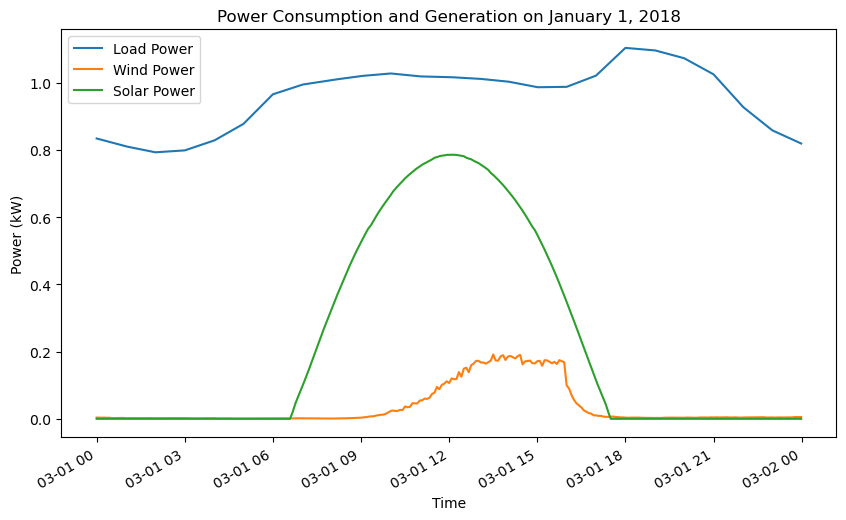

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame
# Convert 'time' to datetime if it's not already
caiso['time'] = pd.to_datetime(caiso['time'])

# Filter data for a specific day, let's say January 1, 2018
start_date = "2018-03-01"
end_date = "2018-03-02"
mask = (caiso['time'] >= start_date) & (caiso['time'] < end_date)
day_data = caiso.loc[mask]

### Step 2: Plotting
# Plotting load_power, wind_power, and solar_power
plt.figure(figsize=(10, 6))
plt.plot(day_data['time'], day_data['load_power'], label='Load Power')
plt.plot(day_data['time'], day_data['wind_power'], label='Wind Power')
plt.plot(day_data['time'], day_data['solar_power'], label='Solar Power')

# Adding titles and labels
plt.title('Power Consumption and Generation One Day')
plt.xlabel('Time')
plt.ylabel('Power (Normalized)')
plt.legend()

# Rotating date labels for better visibility
plt.gcf().autofmt_xdate()

plt.show()
